## Assignment 2

Group members: Jacopo Francesco Amoretti, Roberto Frabetti, Ivo Rambaldi


### Huggingface Login



In [2]:
from huggingface_hub import login
login(token="")

### Data Loading




In [3]:
!pip install -q --upgrade bitsandbytes transformers accelerate

import torch
import pandas as pd
import copy
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 137.7 MB/s eta 0:00:00


In [4]:
!wget https://raw.githubusercontent.com/lt-nlp-lab-unibo/nlp-course-material/main/2025-2026/Assignment%202/data/a2_test.csv
!wget https://raw.githubusercontent.com/lt-nlp-lab-unibo/nlp-course-material/main/2025-2026/Assignment%202/data/demonstrations.csv

print("\n--- Download completato ---")

--2025-11-28 14:15:25--  https://raw.githubusercontent.com/lt-nlp-lab-unibo/nlp-course-material/main/2025-2026/Assignment%202/data/a2_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51789 (51K) [text/plain]
Saving to: ‘a2_test.csv’

a2_test.csv         100%[===================>]  50.58K  --.-KB/s    in 0.001s  

2025-11-28 14:15:25 (39.7 MB/s) - ‘a2_test.csv’ saved [51789/51789]

--2025-11-28 14:15:25--  https://raw.githubusercontent.com/lt-nlp-lab-unibo/nlp-course-material/main/2025-2026/Assignment%202/data/demonstrations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
H

In [5]:
import pandas as pd
test_df = pd.read_csv("a2_test.csv")
print(test_df.head())

                  rewire_id  \
0  sexism2022_english-11647   
1  sexism2022_english-15883   
2  sexism2022_english-12494   
3     sexism2022_english-26   
4   sexism2022_english-7475   

                                                text label_category  
0  She may be worth what someone paid for her in ...     derogation  
1  The men who white knight for women eventually ...     prejudiced  
2  Two thoughts to keep in mind about women and A...     derogation  
3  Wimmin. No matter how good they have it, they'...     prejudiced  
4  So just a few months ago, while Republican wom...     prejudiced  


# [Task 1 - 0.5 points] Model setup


In [6]:
import torch
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# --- Model 1: Phi3-mini ---
model_id_1 = "microsoft/Phi-3-mini-4k-instruct"
print(f"Loading model: {model_id_1}...")
model_1 = AutoModelForCausalLM.from_pretrained(
    model_id_1,
    quantization_config=quantization_config,
    device_map="auto"
)
tokenizer_1 = AutoTokenizer.from_pretrained(model_id_1)

# For safety
if tokenizer_1.pad_token is None:
    tokenizer_1.pad_token = tokenizer_1.eos_token

# Connect tokenizer to the model
model_1.tokenizer = tokenizer_1
print(f"Model {model_id_1} loaded.")

# --- Modello 2: Mistral v3 (7B Instruct) ---
model_id_2 = "mistralai/Mistral-7B-Instruct-v0.3"
print(f"\nLoading model: {model_id_2}...")
model_2 = AutoModelForCausalLM.from_pretrained(
    model_id_2,
    quantization_config=quantization_config,
    device_map="auto"
)
tokenizer_2 = AutoTokenizer.from_pretrained(model_id_2)

# pad token di sicurezza
if tokenizer_2.pad_token is None:
    tokenizer_2.pad_token = tokenizer_2.eos_token

model_2.tokenizer = tokenizer_2
print(f"Model {model_id_2} loaded.")


Loading model: microsoft/Phi-3-mini-4k-instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Model microsoft/Phi-3-mini-4k-instruct loaded.

Loading model: mistralai/Mistral-7B-Instruct-v0.3...


config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Model mistralai/Mistral-7B-Instruct-v0.3 loaded.


# [Task 2 - 1.0 points] Prompt setup



## Prompt Template



In [7]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as not-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         not-sexist, threats, derogation, animosity, prejudiced.

        TEXT: {text}

        ANSWER:
        """
    }
]

### Instructions


In [8]:
def prepare_prompts(texts, prompt_template, tokenizer):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated
      with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  processed_prompts = []

  for text in texts:
    current_prompt_messages = copy.deepcopy(prompt_template)
    current_prompt_messages[1]['content'] = current_prompt_messages[1]['content'].format(text=text)

    final_prompt_string = tokenizer.apply_chat_template(
        current_prompt_messages,
        tokenize=False,
        add_generation_prompt=True
    )
    processed_prompts.append(final_prompt_string)

  return processed_prompts


# [Task 3 - 1.0 points] Inference



In [9]:
def generate_responses(model, prompt_examples):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate
    a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
  """
  model.eval()
  responses = []

  for prompt in tqdm(prompt_examples, desc="Generating"):
      inputs = model.tokenizer(prompt, return_tensors="pt").to(model.device)

      with torch.no_grad():
          output = model.generate(
              **inputs,
              max_new_tokens=30,
              temperature=0.2,
              do_sample=False,
              pad_token_id=model.tokenizer.eos_token_id
          )

      response = model.tokenizer.decode(output[0], skip_special_tokens=True)
      # Extract only the part after "ANSWER:"
      if "ANSWER:" in response:
          response = response.split("ANSWER:")[-1].strip()
      responses.append(response)

  return responses

In [23]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed classification response.
      Use the following mapping:
      {
        'not-sexist': 0,
        'threats': 1,
        'derogation': 2,
        'animosity': 3,
        'prejudiced': 4
      }
  """
  response = response.lower().strip()
  mapping = {
      'not-sexist': 0,
      'threats': 1,
      'derogation': 2,
      'animosity': 3,
      'prejudiced': 4
  }
  for key, val in mapping.items():
      if key in response:
          return val
  return 0  # failed or fallback to not-sexist

label_mapping = {
    'not-sexist': 0,
    'threats': 1,
    'derogation': 2,
    'animosity': 3,
    'prejudiced': 4
}

labels_series = test_df["label_category"].map(label_mapping)

true_labels = labels_series.astype(int).to_numpy()
print("Numero di esempi con label valida:", len(true_labels))

Numero di esempi con label valida: 300


In [11]:
texts = test_df["text"].tolist()

prompts_1 = prepare_prompts(texts, prompt, tokenizer_1)
prompts_2 = prepare_prompts(texts, prompt, tokenizer_2)

# Fix tokenizer reference in generate_responses
model_1.tokenizer = tokenizer_1
model_2.tokenizer = tokenizer_2

print("Starting zero-shot inference...")
raw_resp_1 = generate_responses(model_1, prompts_1)
raw_resp_2 = generate_responses(model_2, prompts_2)

pred_1 = [process_response(r) for r in raw_resp_1]
pred_2 = [process_response(r) for r in raw_resp_2]

Starting zero-shot inference...


Generating: 100%|██████████| 300/300 [02:36<00:00,  1.92it/s]


In [12]:
import pickle

with open("zero_shot_predictions.pkl", "wb") as f:
    pickle.dump({
        "raw_resp_1": raw_resp_1,
        "raw_resp_2": raw_resp_2,
        "pred_1": pred_1,
        "pred_2": pred_2
    }, f)

print("Predizioni salvate!")


Predizioni salvate!


# [Task 4 - 0.5 points] Metrics


In [25]:
def compute_metrics(y_pred, y_true):
  """
    This function takes predicted and ground-truth labels and compute
    metrics. In particular, this function compute accuracy and
    fail-ratio metrics. This function internally invokes
    `process_response` to compute metrics.

    Inputs:
      y_pred: parsed LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """
  # convert to NumPy arrays
  y_pred = np.asarray(y_pred, dtype=int)
  y_true = np.asarray(y_true, dtype=int)

  # (safe-check) trim to equal length
  min_len = min(len(y_pred), len(y_true))
  y_pred = y_pred[:min_len]
  y_true = y_true[:min_len]

  # Macro F1
  macro_f1 = f1_score(y_true, y_pred, average='macro')

  # Fail ratio: predicted not-sexist but true is sexist
  fails = np.sum((y_pred == 0) & (y_true != 0))
  fail_ratio = fails / len(y_true)
  return {
      "macro_f1": float(round(macro_f1, 4)),
      "fail_ratio": float(round(fail_ratio, 4))
  }

In [26]:
os_metrics_1 = compute_metrics(pred_1, true_labels)
os_metrics_2 = compute_metrics(pred_2, true_labels)

print("One-shot Phi3-mini:", os_metrics_1)
print("One-shot Mistralv3:", os_metrics_2)

One-shot Phi3-mini: {'macro_f1': 0.3967, 'fail_ratio': 0.0233}
One-shot Mistralv3: {'macro_f1': 0.3671, 'fail_ratio': 0.0133}


# [Task 5 - 1.0 points] Few-shot Inference



In [16]:
demonstrations_df = pd.read_csv("demonstrations.csv")
print(demonstrations_df.head())

                  rewire_id  \
0   sexism2022_english-7417   
1  sexism2022_english-10155   
2  sexism2022_english-15154   
3  sexism2022_english-13387   
4   sexism2022_english-2990   

                                                text label_sexist  \
0  female egg donors are allowed to be uggo as fu...       sexist   
1  My girlfriend is mentally retarded. Or if you ...       sexist   
2                                    Lock her UP!!!!       sexist   
3  So you want to live in a world where women are...       sexist   
4  Special episode of Loomy Does Politics, by pop...       sexist   

  label_category                                       label_vector  split  
0     derogation                            2.1 descriptive attacks  train  
1     derogation                            2.1 descriptive attacks   test  
2        threats           1.2 incitement and encouragement of harm  train  
3      animosity  3.1 casual use of gendered slurs, profanities,...    dev  
4     prejudi

In [17]:
def build_few_shot_demonstrations(demonstrations, num_per_class):
    """
    Inputs:
      demonstrations: DataFrame wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      list of demonstrations to inject into the prompt template.
    """

    examples = ""
    # qui mi servono i NOMI delle classi, non gli interi
    for label_name in label_mapping.keys():  # 'not-sexist', 'threats', ...
        subset = demonstrations[demonstrations["label_category"] == label_name]

        if subset.empty:
            continue

        subset = subset.sample(
            n=min(num_per_class, len(subset)),
            random_state=42
        )

        for _, row in subset.iterrows():
            examples += f"TEXT: {row['text']}\nANSWER: {label_name}\n\n"

    return examples.strip()

few_shot_examples = build_few_shot_demonstrations(demonstrations_df, num_per_class=2)

# Modified template for few-shot
few_shot_template = copy.deepcopy(prompt)
few_shot_template[1]["content"] = few_shot_template[1]["content"].replace(
    "TEXT: {text}",
    f"EXAMPLES:\n{few_shot_examples}\n\nTEXT: {{text}}"
)

fs_prompts_1 = prepare_prompts(texts, few_shot_template, tokenizer_1)
fs_prompts_2 = prepare_prompts(texts, few_shot_template, tokenizer_2)

print(fs_prompts_1[0]) # RIMUOVERE

print("\nStarting few-shot inference...")
fs_raw_1 = generate_responses(model_1, fs_prompts_1)
fs_raw_2 = generate_responses(model_2, fs_prompts_2)

fs_pred_1 = [process_response(r) for r in fs_raw_1]
fs_pred_2 = [process_response(r) for r in fs_raw_2]


<|system|>
You are an annotator for sexism detection.<|end|>
<|user|>
Your task is to classify input text as not-sexist
         or sexist. If sexist, classify input text according to one
         of the following four categories: threats, derogation,
         animosity, prejudiced discussion.

         Below you find sexist categories definitions:
         Threats: the text expresses intent or desire to harm a woman.
         Derogation: the text describes a woman in a derogative manner.
         Animosity: the text contains slurs or insults towards a woman.
         Prejudiced discussion: the text expresses supports for
         mistreatment of women as individuals.

         Respond only by writing one of the following categories:
         not-sexist, threats, derogation, animosity, prejudiced.

        EXAMPLES:
TEXT: That joke is 100 times better and more apt than what he said. I'd have laughed at that joke. The one he made was reaaaal crap.
ANSWER: not-sexist

TEXT: I think Torba

Generating: 100%|██████████| 300/300 [06:23<00:00,  1.28s/it]


In [27]:
fs_metrics_1 = compute_metrics(fs_pred_1, true_labels)
fs_metrics_2 = compute_metrics(fs_pred_2, true_labels)

print("Few-shot Phi3-mini", fs_metrics_1)
print("Few-shot Mistralv3:", fs_metrics_2)

Few-shot Phi3-mini {'macro_f1': 0.3643, 'fail_ratio': 0.0633}
Few-shot Mistralv3: {'macro_f1': 0.4393, 'fail_ratio': 0.0167}


In [19]:
# Cella temporanea -> Rimuovere a fine progetto
import pickle

few_shot_data = {
    "few_shot_examples": few_shot_examples,
    "fs_raw_1": fs_raw_1,
    "fs_raw_2": fs_raw_2,
    "fs_pred_1": fs_pred_1,
    "fs_pred_2": fs_pred_2,
}

with open("few_shot_predictions.pkl", "wb") as f:
    pickle.dump(few_shot_data, f)

print("Few-shot predictions salvate!")


Few-shot predictions salvate!


# [Task 6 - 1.0 points] Error Analysis




=== Performance Comparison ===
                   Model  Macro F1  Fail Ratio
0  Phi3-mini (zero-shot)    0.3967      0.0233
1  Mistralv3 (zero-shot)    0.3671      0.0133
2   Phi3-mini (few-shot)    0.3643      0.0633
3   Mistralv3 (few-shot)    0.4393      0.0167

=== Confusion Matrix ===


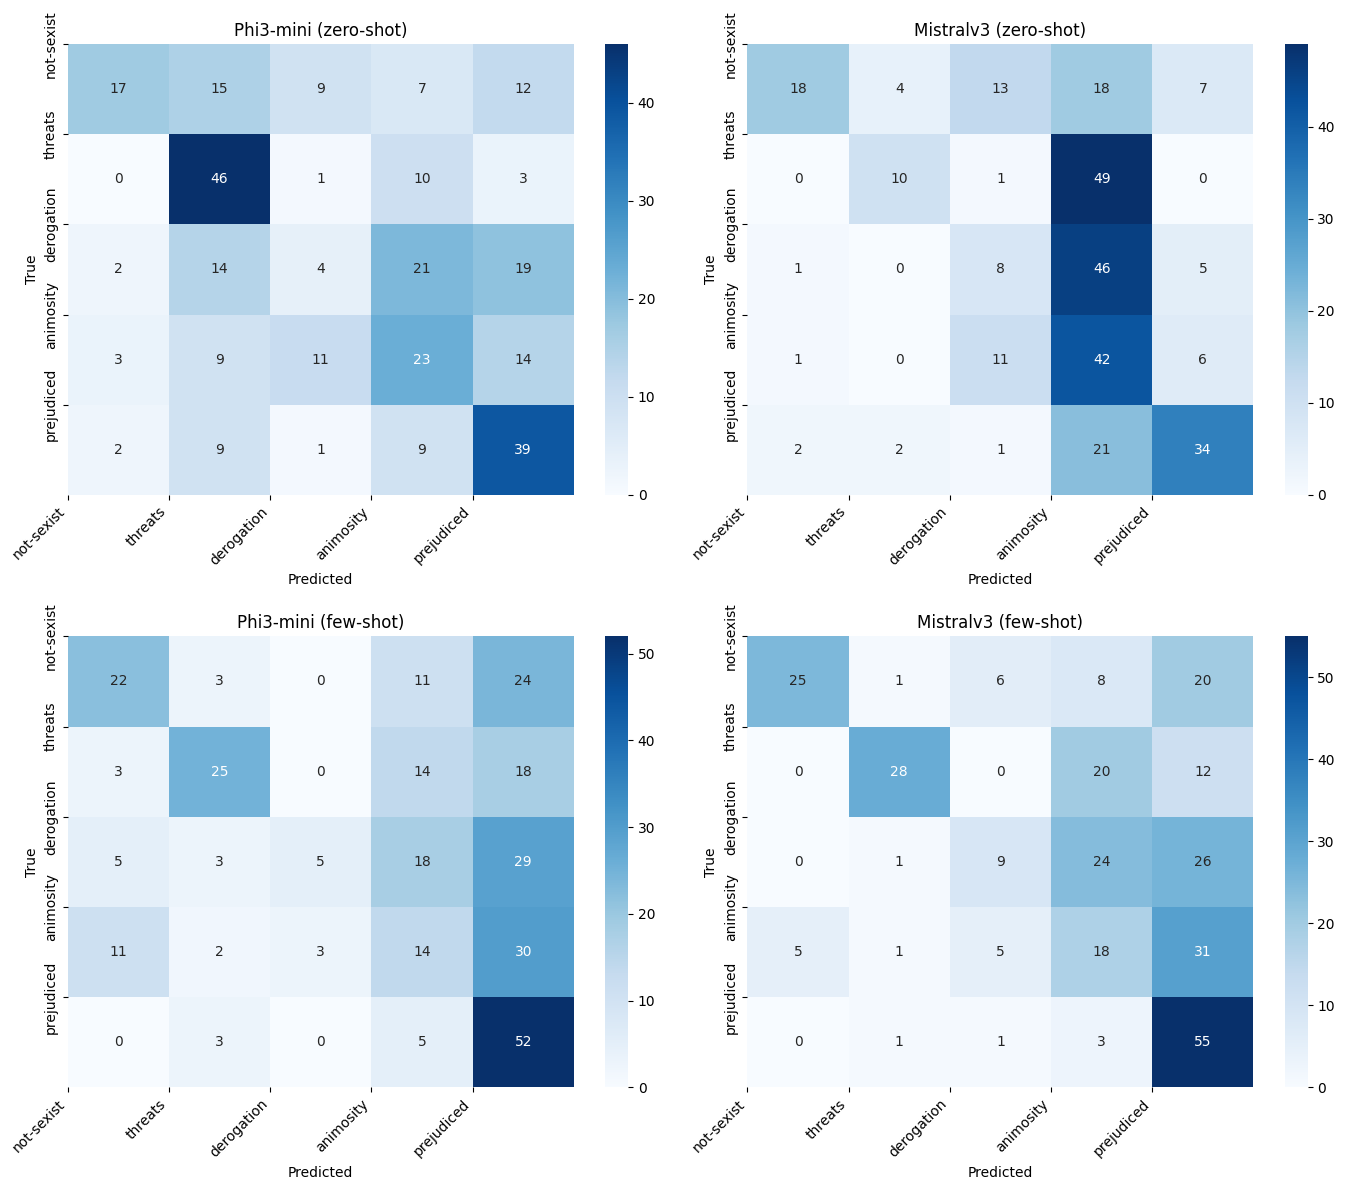

In [22]:
print("\n=== Performance Comparison ===")
print(pd.DataFrame({
    # Nomi dei modelli usati nell'esperimento
    "Model": ["Phi3-mini (zero-shot)", "Mistralv3 (zero-shot)", "Phi3-mini (few-shot)", "Mistralv3 (few-shot)"],

    "Macro F1": [os_metrics_1["macro_f1"], os_metrics_2["macro_f1"],
                 fs_metrics_1["macro_f1"], fs_metrics_2["macro_f1"]],
    "Fail Ratio": [os_metrics_1["fail_ratio"], os_metrics_2["fail_ratio"],
                   fs_metrics_1["fail_ratio"], fs_metrics_2["fail_ratio"]]
}))

print("\n=== Confusion M ===")
fig, axes = plt.subplots(2, 2, figsize=(14,12))

model_results = [
    (pred_1, "Phi3-mini (zero-shot)"),
    (pred_2, "Mistralv3 (zero-shot)"),
    (fs_pred_1, "Phi3-mini (few-shot)"),
    (fs_pred_2, "Mistralv3 (few-shot)")
]

class_names = ['not-sexist', 'threats', 'derogation', 'animosity', 'prejudiced']

for i, (preds, name) in enumerate(model_results):
    ax = axes[i//2, i%2]

    cm = confusion_matrix(true_labels, preds)

    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax)

    # Imposto tick corretti (no numeri grezzi)
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


# Performance Analysis:
**Zero-Shot:** Phi3-mini slightly outperforms Mistralv3 in terms of Macro F1 (0.3967 vs. 0.3671). Both have a low fail ratio (less than 2.5%), this indicate that they follow the instruction to respond with one of the specific categories.

**Few-Shot:** Introducing examples significantly improves Mistralv3, bringing its Macro F1 to 0.4393 with a very low fail ratio (0.0167). In contrast, Phi3-mini shows a performance drop (0.3643) and an increase in fail ratio (0.0633), probably meaning that it may not have benefited as much from the examples provided. We attributed this to the model's small size, which could lead to more errors.

# Confusion Matrix Analysis:
**Zero-Shot:** Phi3-mini struggles with the derogation category (4 correct), while Mistralv3 confuses derogation with animosity (46 cases) and handles threats well (49 correct).

**Few-Shot:** Mistralv3 is the best model, classifying prejudiced excellently (55 corrections), but both models show persistent confusion between the derogation, animosity, and prejudiced categories.
We decided to use K = 2 since Phi3-mini, due to its smallness, produced worse results.
